# Mini CNN Activation Playground (9×9)

This notebook helps visualize how simple 3×3 filters activate on tiny 9×9 inputs.
It includes:
- A pure NumPy **pattern-matching correlation** demo.
- A Keras **Conv2D** layer with fixed weights (so students can see identical activations inside Keras).

**Tip for class:** Have students edit the input pattern or the filter values and observe how the feature maps change.

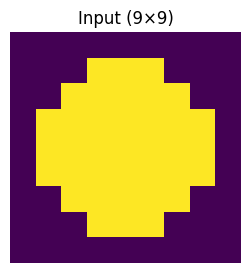

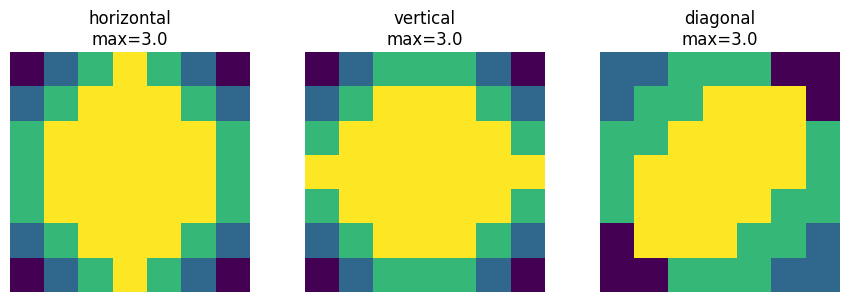

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def make_input(kind="circle", size=9):
    img = np.zeros((size, size), dtype=float)
    c = (size - 1) / 2.0
    rr, cc = np.ogrid[:size, :size]
    if kind == "circle":
        r = (size - 1) / 2.5
        mask = (rr - c) ** 2 + (cc - c) ** 2 <= r ** 2
        img[mask] = 1.0
    elif kind == "hline":
        img[size // 2, :] = 1.0
    elif kind == "vline":
        img[:, size // 2] = 1.0
    elif kind == "diag":
        np.fill_diagonal(img, 1.0)
    elif kind == "anti":
        np.fill_diagonal(np.fliplr(img), 1.0)
    elif kind == "dot":
        img[size // 2, size // 2] = 1.0
    elif kind == "noise":
        img = (np.random.rand(size, size) > 0.7).astype(float)
    else:
        raise ValueError("Unknown kind")
    return img

K_horizontal = np.array([
  [0,0,0],
  [1,1,1],
  [0,0,0]],
  dtype=float
)
K_vertical   = np.array([
  [0,1,0],
  [0,1,0],
  [0,1,0]],
  dtype=float
)
K_diagonal   = np.array([
  [1,0,0],
  [0,1,0],
  [0,0,1]],
  dtype=float
)
kernels = {"horizontal": K_horizontal, "vertical": K_vertical, "diagonal": K_diagonal}

def valid_correlation(img, kernel):
    H, W = img.shape
    kh, kw = kernel.shape
    out = np.zeros((H - kh + 1, W - kw + 1), dtype=float)
    for i in range(out.shape[0]):
        for j in range(out.shape[1]):
            patch = img[i:i+kh, j:j+kw]
            out[i, j] = np.sum(patch * kernel)
    return out

# Try changing the pattern below ("circle", "hline", "vline", "diag", "anti", "dot", "noise")
img = make_input("circle", 9)

plt.figure(figsize=(3,3))
plt.imshow(img, cmap="viridis", interpolation="nearest")
plt.title("Input (9×9)")
plt.axis("off")
plt.show()

fig = plt.figure(figsize=(9,3))
for idx, (kname, K) in enumerate(kernels.items()):
    fmap = valid_correlation(img, K)
    ax = fig.add_subplot(1, 3, idx+1)
    ax.imshow(fmap, cmap="viridis", interpolation="nearest")
    ax.set_title(f"{kname}\nmax={np.max(fmap):.1f}")
    ax.axis("off")
plt.tight_layout()
plt.show()

## Keras version (optional)

This reproduces the same activations using a `Conv2D` layer with **fixed weights**.
Note: Keras conv flips kernels internally (convolution vs correlation). Because our
kernels are symmetric along their signal direction, the effect here is the same. If you
use asymmetric kernels, use `np.flip` when assigning to match Keras' convention.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/Users/ssogden/repos/classes/CST463-golden/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


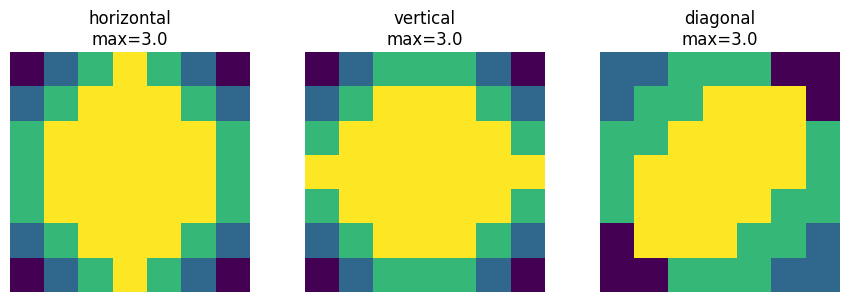

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# Reuse the same kernels
K_horizontal = np.array([[0,0,0],[1,1,1],[0,0,0]], dtype=float)
K_vertical   = np.array([[0,1,0],[0,1,0],[0,1,0]], dtype=float)
K_diagonal   = np.array([[1,0,0],[0,1,0],[0,0,1]], dtype=float)
kernels = [K_horizontal, K_vertical, K_diagonal]

# Build a Conv2D with 3 filters of size 3×3, 1 input channel
conv = layers.Conv2D(filters=3, kernel_size=(3,3), use_bias=False, padding='valid', input_shape=(9,9,1))

# Initialize weights: shape (kh, kw, in_ch, out_ch) = (3,3,1,3)
W = np.stack(kernels, axis=-1).astype(np.float32)  # (3,3,3) — currently (kh, kw, out_ch)
W = np.expand_dims(W, axis=2)                      # (3,3,1,3)
conv.build((None, 9, 9, 1))
conv.set_weights([W])

model = models.Sequential([conv])

# Create an input and run it
def make_input(kind="circle", size=9):
    img = np.zeros((size, size), dtype=float)
    c = (size - 1) / 2.0
    rr, cc = np.ogrid[:size, :size]
    if kind == "circle":
        r = (size - 1) / 2.5
        mask = (rr - c) ** 2 + (cc - c) ** 2 <= r ** 2
        img[mask] = 1.0
    elif kind == "hline":
        img[size // 2, :] = 1.0
    elif kind == "vline":
        img[:, size // 2] = 1.0
    elif kind == "diag":
        np.fill_diagonal(img, 1.0)
    elif kind == "anti":
        np.fill_diagonal(np.fliplr(img), 1.0)
    elif kind == "dot":
        img[size // 2, size // 2] = 1.0
    elif kind == "noise":
        img = (np.random.rand(size, size) > 0.7).astype(float)
    else:
        raise ValueError("Unknown kind")
    return img

img = make_input("circle", 9).astype(np.float32)
x = img[None, ..., None]  # (1, 9, 9, 1)
y = model.predict(x)

fig = plt.figure(figsize=(9,3))
titles = ["horizontal", "vertical", "diagonal"]
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    ax.imshow(y[0, :, :, i], cmap="viridis", interpolation="nearest")
    ax.set_title(f"{titles[i]}\nmax={np.max(y[0,:,:,i]):.1f}")
    ax.axis("off")
plt.tight_layout()
plt.show()

### Ideas to explore
- Change the input to `"hline"`, `"vline"`, `"diag"`, `"anti"`, `"dot"`, or `"noise"`.
- Add an **anti-diagonal** filter or a **Sobel** edge detector and compare responses.
- Try **padding='same'** vs **'valid'** in Keras and see output sizes.
- Add a `ReLU` after the conv and talk about non-linearities.